         Date        Low       Open    Volume       High      Close  \
0  18-11-1999  28.612303  32.546494  62546380  35.765381  31.473534   
1  19-11-1999  28.478184  30.713518  15234146  30.758226  28.880545   
2  22-11-1999  28.657009  29.551144   6577870  31.473534  31.473534   
3  23-11-1999  28.612303  30.400572   5975611  31.205294  28.612303   
4  24-11-1999  28.612303  28.701717   4843231  29.998213  29.372318   

   Adjusted Close  
0       27.066582  
1       24.836662  
2       27.066582  
3       24.605980  
4       25.259573  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5804 entries, 0 to 5803
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            5804 non-null   object 
 1   Low             5804 non-null   float64
 2   Open            5804 non-null   float64
 3   Volume          5804 non-null   int64  
 4   High            5804 non-null   float64
 5   Close           5804 non-nu

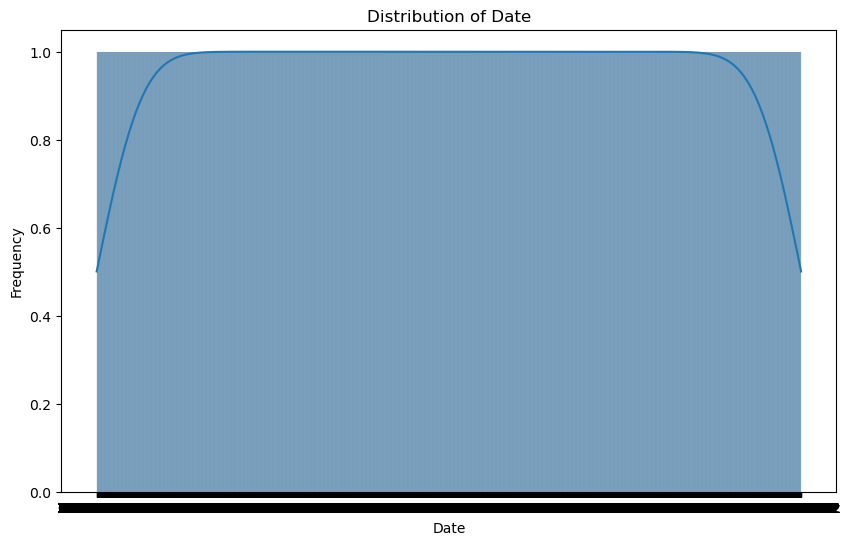

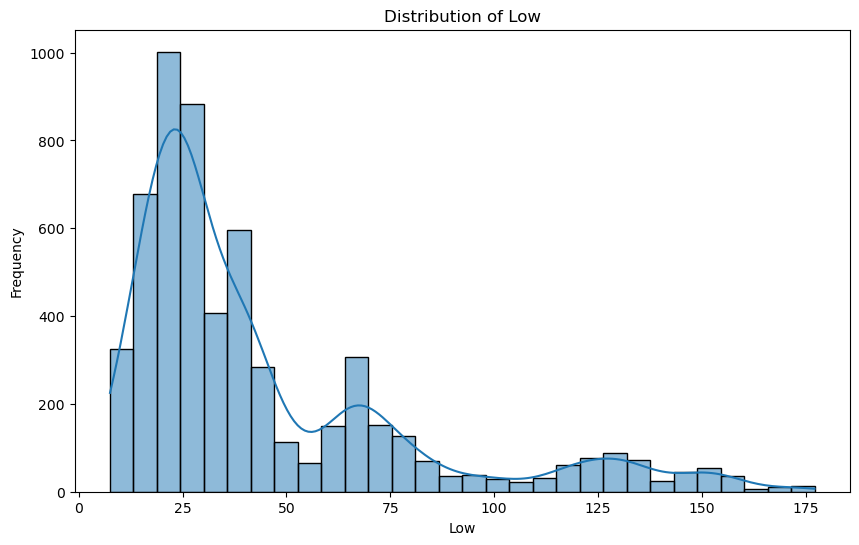

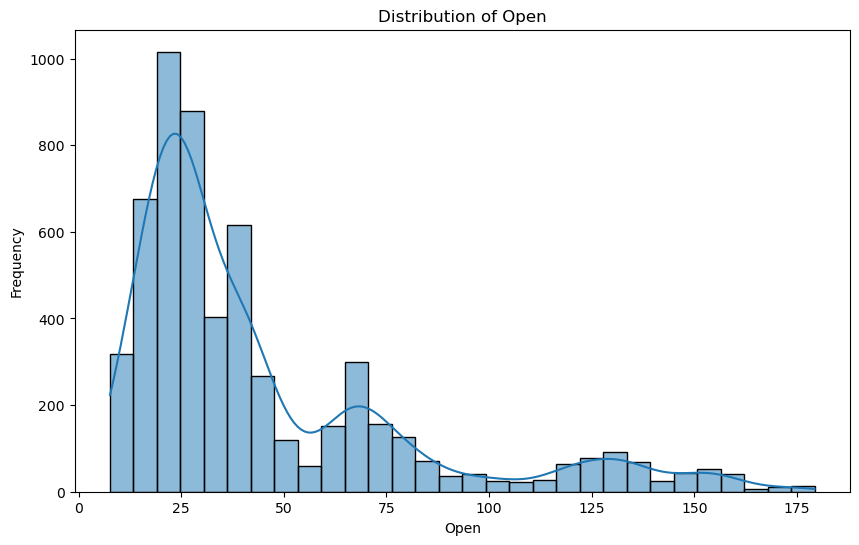

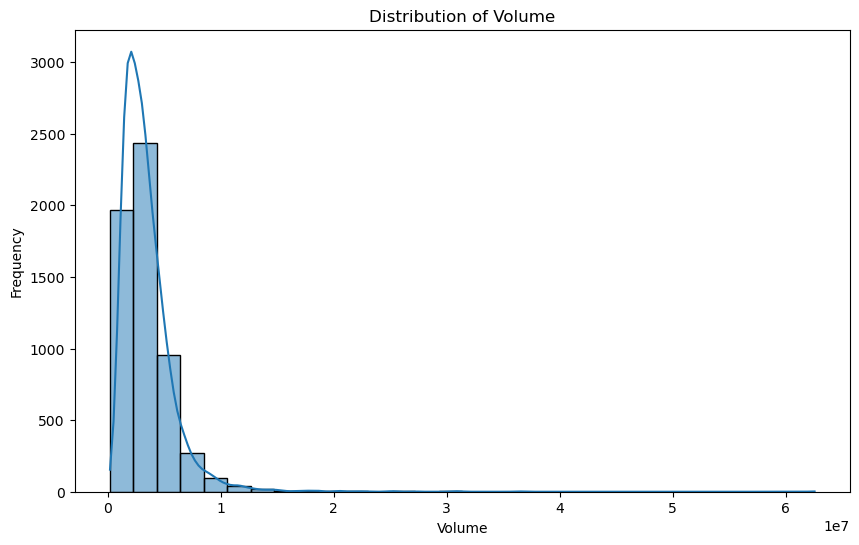

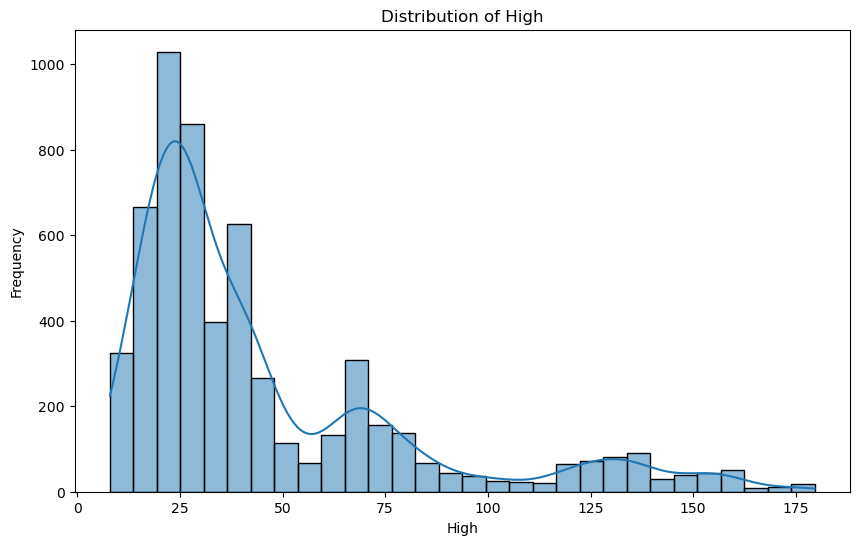

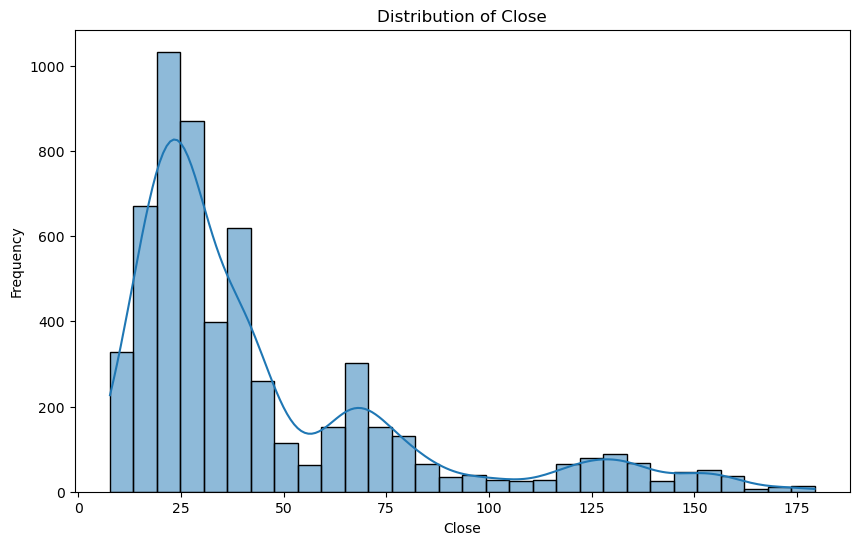

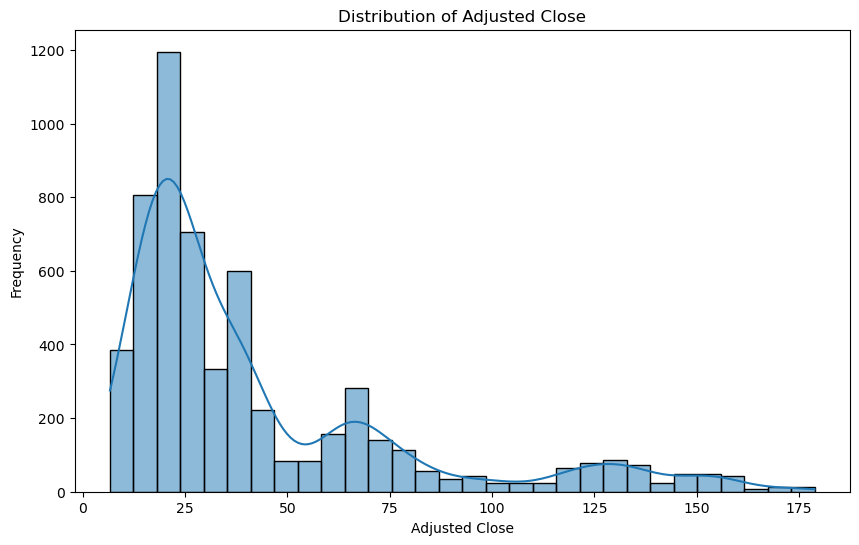

C:\Users\asus\AppData\Local\Temp\ipykernel_5572\3654095411.py:31: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['Date'] = pd.to_datetime(data['Date'])


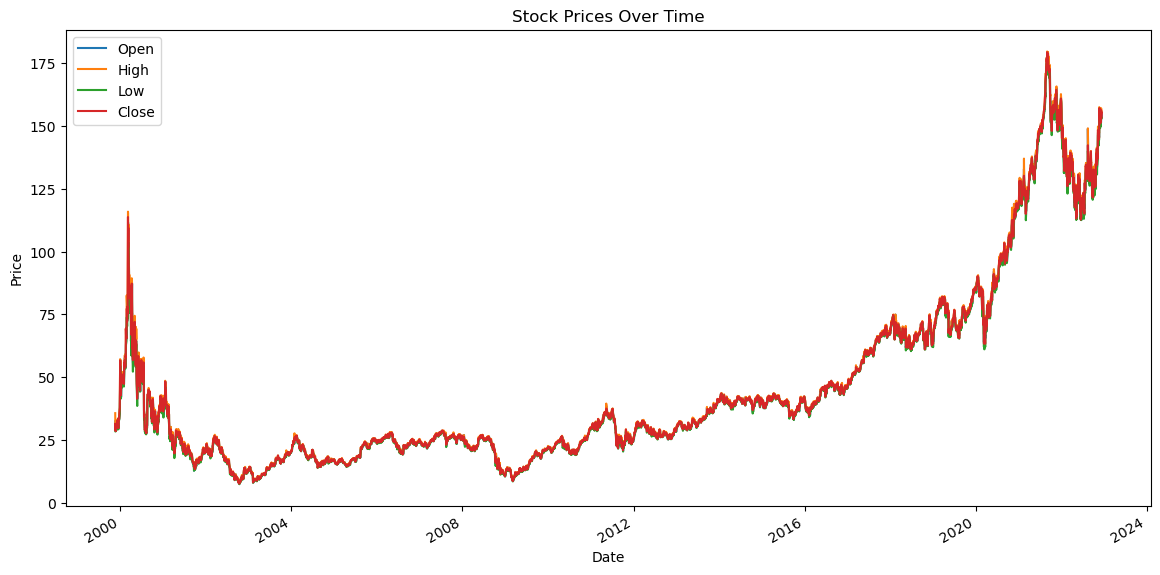

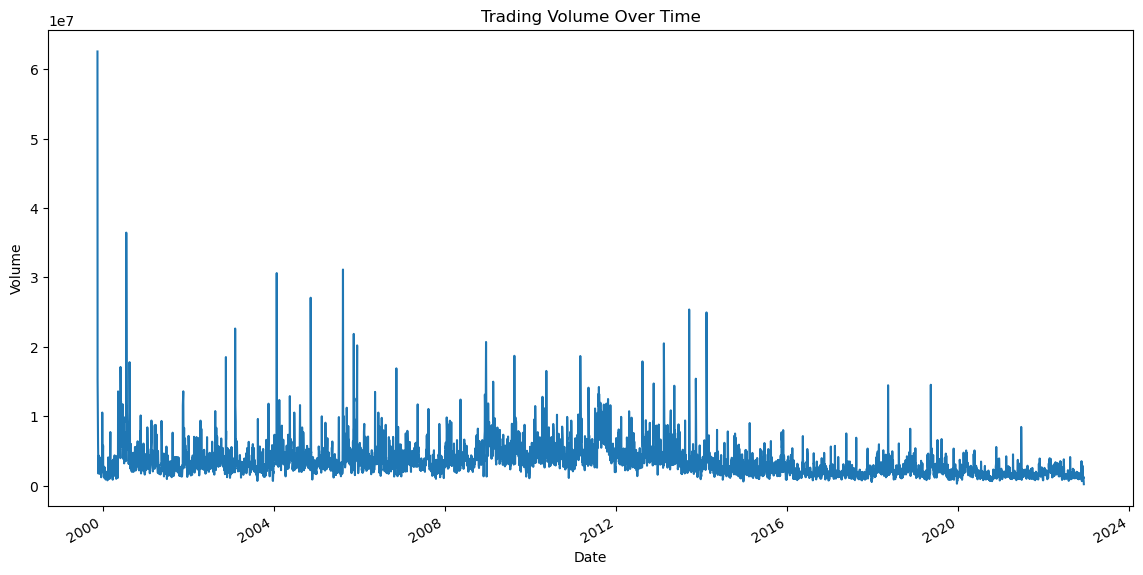

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load Dataset
file_path = 'A.csv' 
data = pd.read_csv(file_path)

# View the first few rows of the dataset
print(data.head())
print(data.info())
Check for missing values
print(data.isnull().sum())
print(data.describe())
# Visualize the distribution of data in each column
for column in data.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(data[column], kde=True, bins=30)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

# Visualize time series data
if 'Date' in data.columns:  
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    data[['Open', 'High', 'Low', 'Close']].plot(figsize=(14, 7))
    plt.title('Stock Prices Over Time')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()

# View time-series changes in trading volume
if 'Volume' in data.columns:
    data['Volume'].plot(figsize=(14, 7))
    plt.title('Trading Volume Over Time')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.show()


In [3]:
data['Volume'] = data['Volume'].astype(float)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5804 entries, 1999-11-18 to 2022-12-12
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Low             5804 non-null   float64
 1   Open            5804 non-null   float64
 2   Volume          5804 non-null   float64
 3   High            5804 non-null   float64
 4   Close           5804 non-null   float64
 5   Adjusted Close  5804 non-null   float64
dtypes: float64(6)
memory usage: 317.4 KB


In [4]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

def preprocess_data(data, time_steps=30, forecast_steps=5, val_ratio=0.2, test_ratio=0.2):
   
    # Normalized Numerical Characteristics
    features = ['Open', 'High', 'Low', 'Close', 'Volume']
    scaler = MinMaxScaler()
    data[features] = scaler.fit_transform(data[features])

    # Constructing time series windows
    def create_sequences(data, time_steps, forecast_steps):
        
        X, y, dates = [], [], []
        for i in range(len(data) - time_steps - forecast_steps + 1):
            X.append(data.iloc[i:i + time_steps][features].values)  
            y.append(data.iloc[i + time_steps:i + time_steps + forecast_steps]['Close'].values) 
            dates.append(data.index[i + time_steps:i + time_steps + forecast_steps])  
        return np.array(X), np.array(y), dates

    X, y, dates = create_sequences(data, time_steps, forecast_steps)

    # Split the dataset chronologically
    X_train, X_temp, y_train, y_temp, dates_train, dates_temp = train_test_split(
        X, y, dates, test_size=val_ratio + test_ratio, shuffle=False
    )
    val_ratio_adjusted = val_ratio / (val_ratio + test_ratio) 
    X_val, X_test, y_val, y_test, dates_val, dates_test = train_test_split(
        X_temp, y_temp, dates_temp, test_size=1 - val_ratio_adjusted, shuffle=False
    )

    return (X_train, y_train, dates_train), (X_val, y_val, dates_val), (X_test, y_test, dates_test), scaler

if __name__ == "__main__":
    (X_train, y_train, dates_train), (X_val, y_val, dates_val), (X_test, y_test, dates_test), scaler = preprocess_data(data)
    print(f"Training set: X={X_train.shape}, y={y_train.shape}, dates={len(dates_train)}")
    print(f"Validation set: X={X_val.shape}, y={y_val.shape}, dates={len(dates_val)}")
    print(f"Test set: X={X_test.shape}, y={y_test.shape}, dates={len(dates_test)}")

Training set: X=(3462, 30, 5), y=(3462, 5), dates=3462
Validation set: X=(1154, 30, 5), y=(1154, 5), dates=1154
Test set: X=(1154, 30, 5), y=(1154, 5), dates=1154


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import Adam
from sklearn.metrics import mean_squared_error

# Vanilla RNN 
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.2):
        super(VanillaRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.rnn.num_layers, x.size(0), self.rnn.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        return self.fc(out[:, -1, :])

# LSTM 
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.2):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        return self.fc(out[:, -1, :])

# GRU 
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.2):
        super(GRU, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.gru.num_layers, x.size(0), self.gru.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        return self.fc(out[:, -1, :])


Tuning Vanilla RNN...
Training VanillaRNN with hidden_size=32, lr=0.0001, weight_decay=0.0001


F:\anaconda\envs\Deeplearning_new\lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [1/20], Train Loss: 0.0081, Val Loss: 0.0175
Epoch [2/20], Train Loss: 0.0025, Val Loss: 0.0118
Epoch [3/20], Train Loss: 0.0021, Val Loss: 0.0102
Epoch [4/20], Train Loss: 0.0018, Val Loss: 0.0080
Epoch [5/20], Train Loss: 0.0014, Val Loss: 0.0060
Epoch [6/20], Train Loss: 0.0011, Val Loss: 0.0039
Epoch [7/20], Train Loss: 0.0007, Val Loss: 0.0020
Epoch [8/20], Train Loss: 0.0005, Val Loss: 0.0010
Epoch [9/20], Train Loss: 0.0003, Val Loss: 0.0005
Epoch [10/20], Train Loss: 0.0002, Val Loss: 0.0003
Epoch [11/20], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [12/20], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [13/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [14/20], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [15/20], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [16/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [17/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [18/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [19/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [20/20], Train 

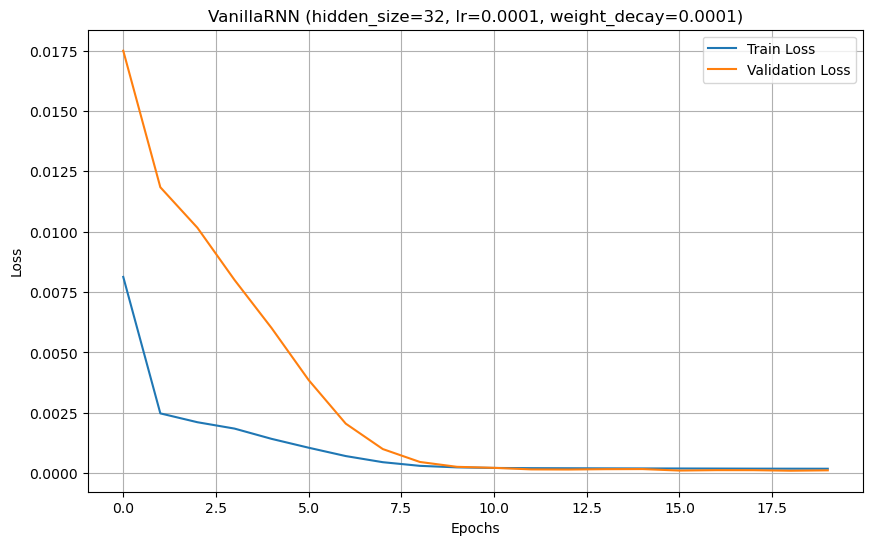

Training VanillaRNN with hidden_size=32, lr=0.0001, weight_decay=0.001
Epoch [1/20], Train Loss: 0.0054, Val Loss: 0.0179
Epoch [2/20], Train Loss: 0.0032, Val Loss: 0.0154
Epoch [3/20], Train Loss: 0.0027, Val Loss: 0.0135
Epoch [4/20], Train Loss: 0.0021, Val Loss: 0.0083
Epoch [5/20], Train Loss: 0.0013, Val Loss: 0.0038
Epoch [6/20], Train Loss: 0.0005, Val Loss: 0.0007
Epoch [7/20], Train Loss: 0.0003, Val Loss: 0.0003
Epoch [8/20], Train Loss: 0.0003, Val Loss: 0.0003
Epoch [9/20], Train Loss: 0.0002, Val Loss: 0.0003
Epoch [10/20], Train Loss: 0.0002, Val Loss: 0.0003
Epoch [11/20], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [12/20], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [13/20], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [14/20], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [15/20], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [16/20], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [17/20], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [18/20], Train Loss: 0.0002, Val Loss: 0.0002
Ep

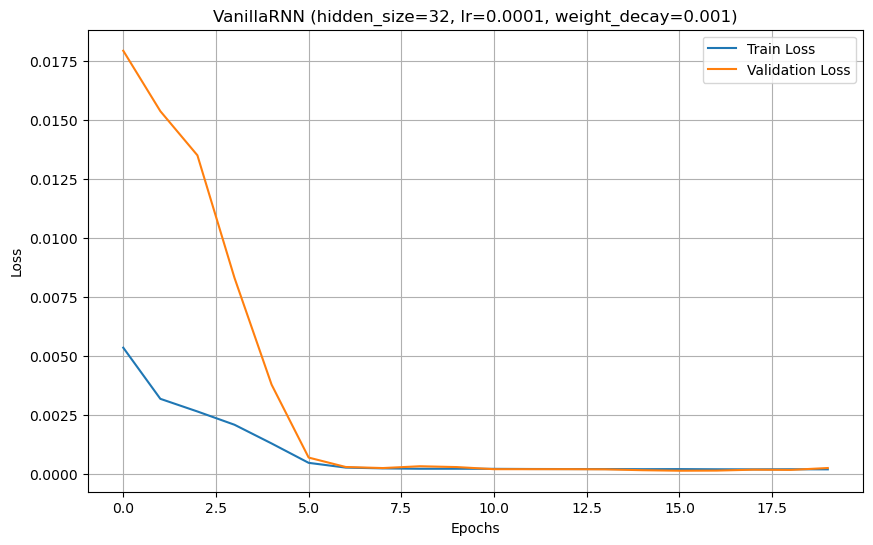

Training VanillaRNN with hidden_size=32, lr=5e-05, weight_decay=0.0001
Epoch [1/20], Train Loss: 0.0417, Val Loss: 0.0563
Epoch [2/20], Train Loss: 0.0175, Val Loss: 0.0313
Epoch [3/20], Train Loss: 0.0066, Val Loss: 0.0220
Epoch [4/20], Train Loss: 0.0038, Val Loss: 0.0199
Epoch [5/20], Train Loss: 0.0034, Val Loss: 0.0186
Epoch [6/20], Train Loss: 0.0032, Val Loss: 0.0168
Epoch [7/20], Train Loss: 0.0030, Val Loss: 0.0156
Epoch [8/20], Train Loss: 0.0028, Val Loss: 0.0144
Epoch [9/20], Train Loss: 0.0025, Val Loss: 0.0133
Epoch [10/20], Train Loss: 0.0023, Val Loss: 0.0119
Epoch [11/20], Train Loss: 0.0021, Val Loss: 0.0106
Epoch [12/20], Train Loss: 0.0018, Val Loss: 0.0092
Epoch [13/20], Train Loss: 0.0016, Val Loss: 0.0077
Epoch [14/20], Train Loss: 0.0013, Val Loss: 0.0058
Epoch [15/20], Train Loss: 0.0010, Val Loss: 0.0043
Epoch [16/20], Train Loss: 0.0008, Val Loss: 0.0031
Epoch [17/20], Train Loss: 0.0006, Val Loss: 0.0022
Epoch [18/20], Train Loss: 0.0005, Val Loss: 0.0015
Ep

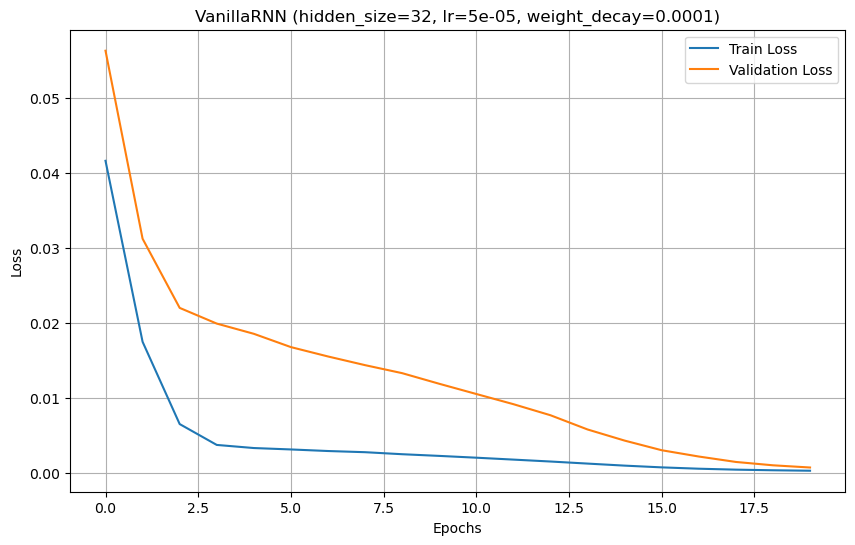

Training VanillaRNN with hidden_size=32, lr=5e-05, weight_decay=0.001
Epoch [1/20], Train Loss: 0.0186, Val Loss: 0.0458
Epoch [2/20], Train Loss: 0.0071, Val Loss: 0.0260
Epoch [3/20], Train Loss: 0.0033, Val Loss: 0.0171
Epoch [4/20], Train Loss: 0.0027, Val Loss: 0.0149
Epoch [5/20], Train Loss: 0.0025, Val Loss: 0.0131
Epoch [6/20], Train Loss: 0.0023, Val Loss: 0.0121
Epoch [7/20], Train Loss: 0.0020, Val Loss: 0.0106
Epoch [8/20], Train Loss: 0.0017, Val Loss: 0.0088
Epoch [9/20], Train Loss: 0.0014, Val Loss: 0.0070
Epoch [10/20], Train Loss: 0.0011, Val Loss: 0.0053
Epoch [11/20], Train Loss: 0.0008, Val Loss: 0.0035
Epoch [12/20], Train Loss: 0.0006, Val Loss: 0.0021
Epoch [13/20], Train Loss: 0.0004, Val Loss: 0.0013
Epoch [14/20], Train Loss: 0.0003, Val Loss: 0.0009
Epoch [15/20], Train Loss: 0.0003, Val Loss: 0.0006
Epoch [16/20], Train Loss: 0.0002, Val Loss: 0.0004
Epoch [17/20], Train Loss: 0.0002, Val Loss: 0.0004
Epoch [18/20], Train Loss: 0.0002, Val Loss: 0.0003
Epo

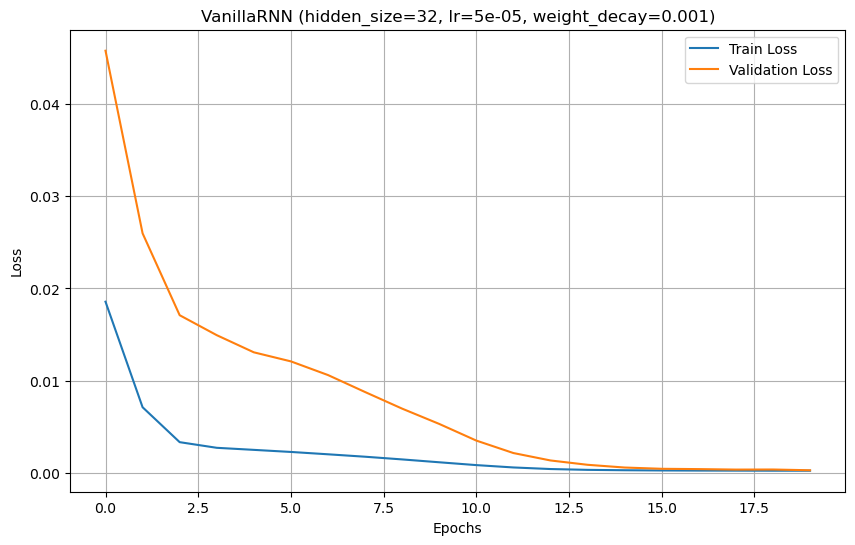

Training VanillaRNN with hidden_size=64, lr=0.0001, weight_decay=0.0001
Epoch [1/20], Train Loss: 0.0055, Val Loss: 0.0179
Epoch [2/20], Train Loss: 0.0025, Val Loss: 0.0080
Epoch [3/20], Train Loss: 0.0008, Val Loss: 0.0003
Epoch [4/20], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [5/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [6/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [7/20], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [8/20], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [9/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [10/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [11/20], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [12/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [13/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [14/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [15/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [16/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [17/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [18/20], Train Loss: 0.0002, Val Loss: 0.0002
E

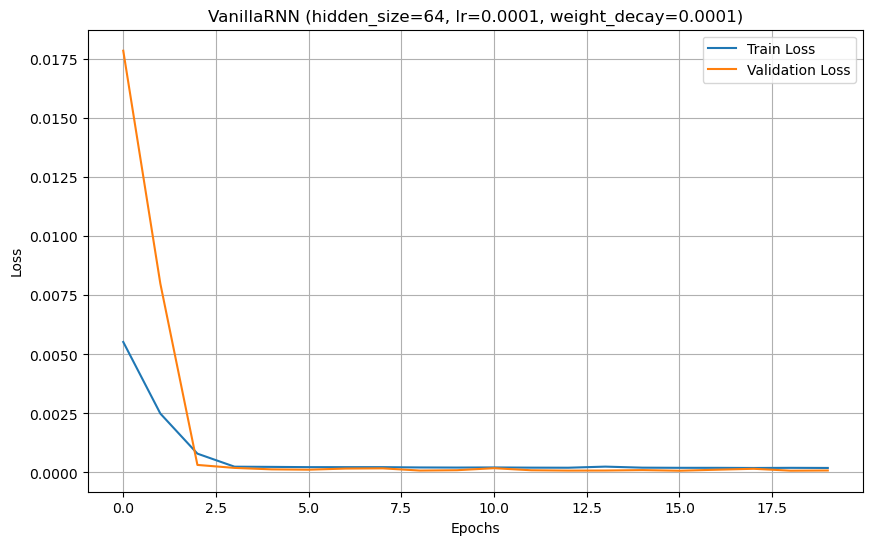

Training VanillaRNN with hidden_size=64, lr=0.0001, weight_decay=0.001
Epoch [1/20], Train Loss: 0.0057, Val Loss: 0.0159
Epoch [2/20], Train Loss: 0.0024, Val Loss: 0.0111
Epoch [3/20], Train Loss: 0.0014, Val Loss: 0.0025
Epoch [4/20], Train Loss: 0.0003, Val Loss: 0.0003
Epoch [5/20], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [6/20], Train Loss: 0.0002, Val Loss: 0.0003
Epoch [7/20], Train Loss: 0.0002, Val Loss: 0.0003
Epoch [8/20], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [9/20], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [10/20], Train Loss: 0.0002, Val Loss: 0.0003
Epoch [11/20], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [12/20], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [13/20], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [14/20], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [15/20], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [16/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [17/20], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [18/20], Train Loss: 0.0002, Val Loss: 0.0001
Ep

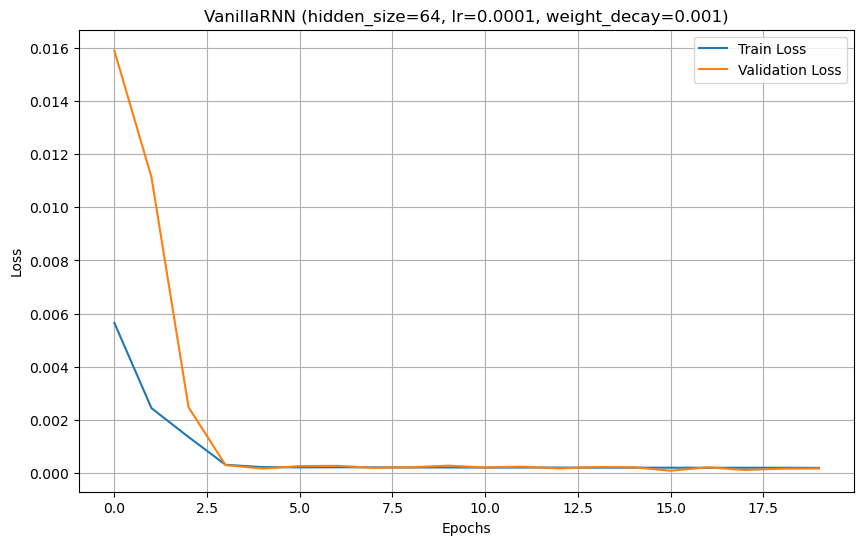

Training VanillaRNN with hidden_size=64, lr=5e-05, weight_decay=0.0001
Epoch [1/20], Train Loss: 0.0184, Val Loss: 0.0297
Epoch [2/20], Train Loss: 0.0034, Val Loss: 0.0144
Epoch [3/20], Train Loss: 0.0025, Val Loss: 0.0130
Epoch [4/20], Train Loss: 0.0021, Val Loss: 0.0105
Epoch [5/20], Train Loss: 0.0017, Val Loss: 0.0078
Epoch [6/20], Train Loss: 0.0012, Val Loss: 0.0043
Epoch [7/20], Train Loss: 0.0006, Val Loss: 0.0014
Epoch [8/20], Train Loss: 0.0003, Val Loss: 0.0004
Epoch [9/20], Train Loss: 0.0003, Val Loss: 0.0003
Epoch [10/20], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [11/20], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [12/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [13/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [14/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [15/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [16/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [17/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [18/20], Train Loss: 0.0002, Val Loss: 0.0001
Ep

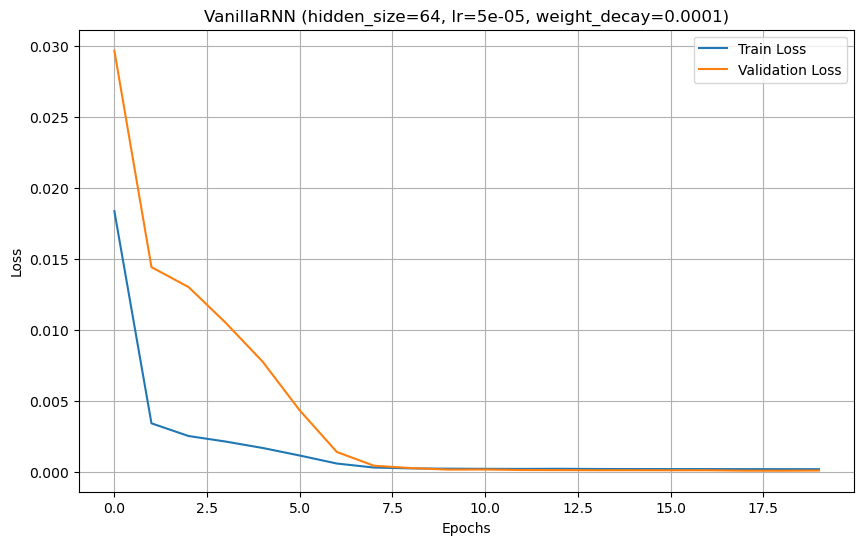

Training VanillaRNN with hidden_size=64, lr=5e-05, weight_decay=0.001
Epoch [1/20], Train Loss: 0.0083, Val Loss: 0.0192
Epoch [2/20], Train Loss: 0.0030, Val Loss: 0.0157
Epoch [3/20], Train Loss: 0.0026, Val Loss: 0.0131
Epoch [4/20], Train Loss: 0.0020, Val Loss: 0.0095
Epoch [5/20], Train Loss: 0.0011, Val Loss: 0.0022
Epoch [6/20], Train Loss: 0.0003, Val Loss: 0.0003
Epoch [7/20], Train Loss: 0.0002, Val Loss: 0.0003
Epoch [8/20], Train Loss: 0.0002, Val Loss: 0.0003
Epoch [9/20], Train Loss: 0.0002, Val Loss: 0.0003
Epoch [10/20], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [11/20], Train Loss: 0.0003, Val Loss: 0.0002
Epoch [12/20], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [13/20], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [14/20], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [15/20], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [16/20], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [17/20], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [18/20], Train Loss: 0.0002, Val Loss: 0.0002
Epo

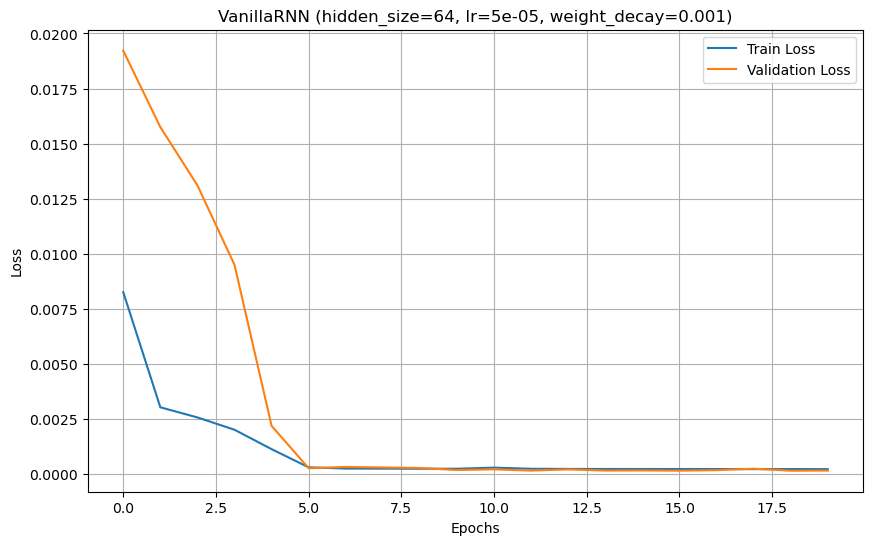

Tuning LSTM...
Training LSTM with hidden_size=32, lr=0.0001, weight_decay=0.0001
Epoch [1/20], Train Loss: 0.0281, Val Loss: 0.0582
Epoch [2/20], Train Loss: 0.0084, Val Loss: 0.0177
Epoch [3/20], Train Loss: 0.0026, Val Loss: 0.0124
Epoch [4/20], Train Loss: 0.0020, Val Loss: 0.0084
Epoch [5/20], Train Loss: 0.0014, Val Loss: 0.0046
Epoch [6/20], Train Loss: 0.0008, Val Loss: 0.0011
Epoch [7/20], Train Loss: 0.0004, Val Loss: 0.0003
Epoch [8/20], Train Loss: 0.0004, Val Loss: 0.0002
Epoch [9/20], Train Loss: 0.0003, Val Loss: 0.0002
Epoch [10/20], Train Loss: 0.0003, Val Loss: 0.0002
Epoch [11/20], Train Loss: 0.0003, Val Loss: 0.0001
Epoch [12/20], Train Loss: 0.0003, Val Loss: 0.0001
Epoch [13/20], Train Loss: 0.0003, Val Loss: 0.0001
Epoch [14/20], Train Loss: 0.0003, Val Loss: 0.0001
Epoch [15/20], Train Loss: 0.0003, Val Loss: 0.0001
Epoch [16/20], Train Loss: 0.0003, Val Loss: 0.0001
Epoch [17/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [18/20], Train Loss: 0.0002, Val Loss:

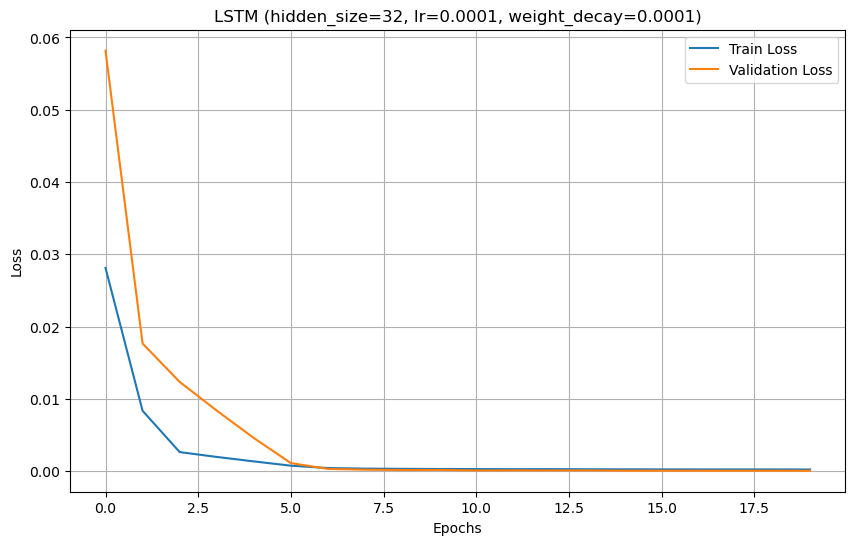

Training LSTM with hidden_size=32, lr=0.0001, weight_decay=0.001
Epoch [1/20], Train Loss: 0.0196, Val Loss: 0.0517
Epoch [2/20], Train Loss: 0.0102, Val Loss: 0.0320
Epoch [3/20], Train Loss: 0.0047, Val Loss: 0.0192
Epoch [4/20], Train Loss: 0.0030, Val Loss: 0.0163
Epoch [5/20], Train Loss: 0.0028, Val Loss: 0.0153
Epoch [6/20], Train Loss: 0.0026, Val Loss: 0.0140
Epoch [7/20], Train Loss: 0.0024, Val Loss: 0.0128
Epoch [8/20], Train Loss: 0.0022, Val Loss: 0.0108
Epoch [9/20], Train Loss: 0.0019, Val Loss: 0.0099
Epoch [10/20], Train Loss: 0.0016, Val Loss: 0.0077
Epoch [11/20], Train Loss: 0.0013, Val Loss: 0.0061
Epoch [12/20], Train Loss: 0.0010, Val Loss: 0.0043
Epoch [13/20], Train Loss: 0.0007, Val Loss: 0.0027
Epoch [14/20], Train Loss: 0.0006, Val Loss: 0.0016
Epoch [15/20], Train Loss: 0.0004, Val Loss: 0.0011
Epoch [16/20], Train Loss: 0.0004, Val Loss: 0.0009
Epoch [17/20], Train Loss: 0.0003, Val Loss: 0.0008
Epoch [18/20], Train Loss: 0.0003, Val Loss: 0.0009
Epoch [1

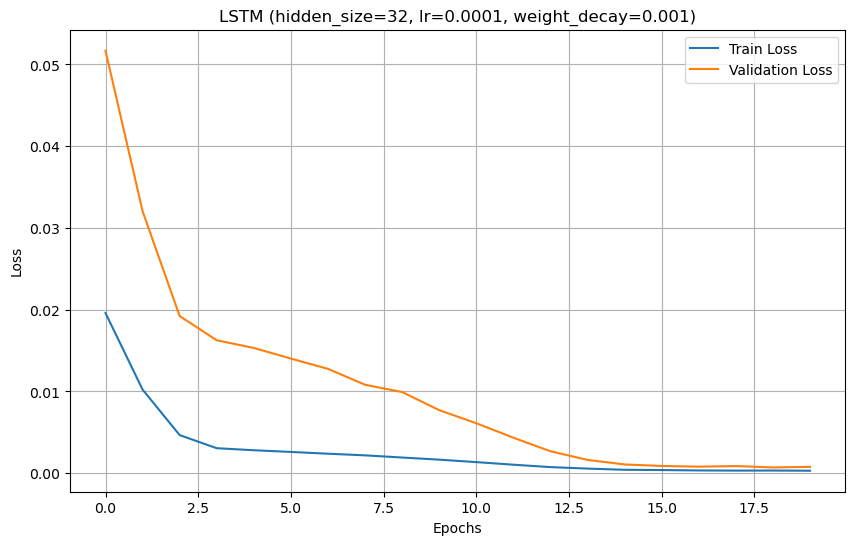

Training LSTM with hidden_size=32, lr=5e-05, weight_decay=0.0001
Epoch [1/20], Train Loss: 0.0153, Val Loss: 0.0468
Epoch [2/20], Train Loss: 0.0098, Val Loss: 0.0354
Epoch [3/20], Train Loss: 0.0062, Val Loss: 0.0260
Epoch [4/20], Train Loss: 0.0042, Val Loss: 0.0203
Epoch [5/20], Train Loss: 0.0033, Val Loss: 0.0174
Epoch [6/20], Train Loss: 0.0029, Val Loss: 0.0161
Epoch [7/20], Train Loss: 0.0027, Val Loss: 0.0139
Epoch [8/20], Train Loss: 0.0025, Val Loss: 0.0131
Epoch [9/20], Train Loss: 0.0023, Val Loss: 0.0110
Epoch [10/20], Train Loss: 0.0019, Val Loss: 0.0085
Epoch [11/20], Train Loss: 0.0016, Val Loss: 0.0063
Epoch [12/20], Train Loss: 0.0011, Val Loss: 0.0039
Epoch [13/20], Train Loss: 0.0007, Val Loss: 0.0012
Epoch [14/20], Train Loss: 0.0004, Val Loss: 0.0003
Epoch [15/20], Train Loss: 0.0004, Val Loss: 0.0002
Epoch [16/20], Train Loss: 0.0003, Val Loss: 0.0002
Epoch [17/20], Train Loss: 0.0003, Val Loss: 0.0001
Epoch [18/20], Train Loss: 0.0003, Val Loss: 0.0001
Epoch [1

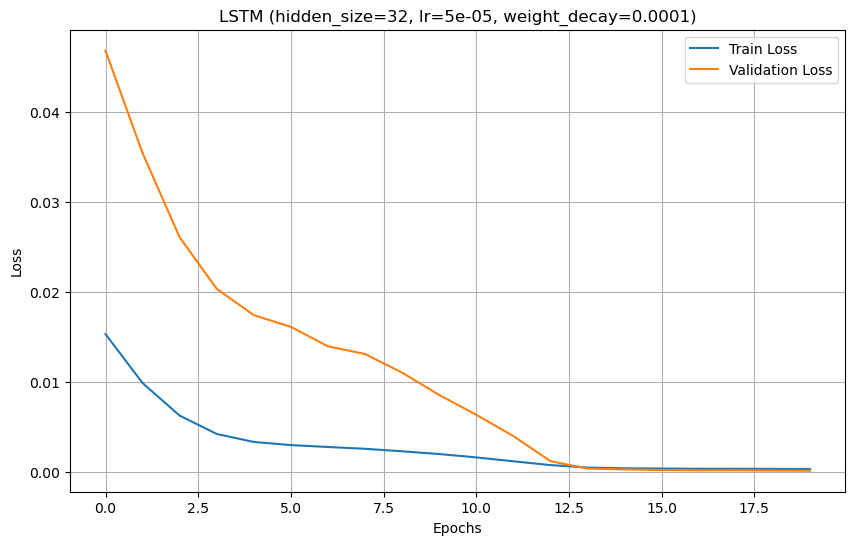

Training LSTM with hidden_size=32, lr=5e-05, weight_decay=0.001
Epoch [1/20], Train Loss: 0.0196, Val Loss: 0.0585
Epoch [2/20], Train Loss: 0.0124, Val Loss: 0.0420
Epoch [3/20], Train Loss: 0.0072, Val Loss: 0.0292
Epoch [4/20], Train Loss: 0.0042, Val Loss: 0.0225
Epoch [5/20], Train Loss: 0.0033, Val Loss: 0.0182
Epoch [6/20], Train Loss: 0.0031, Val Loss: 0.0171
Epoch [7/20], Train Loss: 0.0029, Val Loss: 0.0164
Epoch [8/20], Train Loss: 0.0029, Val Loss: 0.0157
Epoch [9/20], Train Loss: 0.0028, Val Loss: 0.0152
Epoch [10/20], Train Loss: 0.0027, Val Loss: 0.0146
Epoch [11/20], Train Loss: 0.0026, Val Loss: 0.0146
Epoch [12/20], Train Loss: 0.0025, Val Loss: 0.0146
Epoch [13/20], Train Loss: 0.0024, Val Loss: 0.0134
Epoch [14/20], Train Loss: 0.0024, Val Loss: 0.0126
Epoch [15/20], Train Loss: 0.0023, Val Loss: 0.0121
Epoch [16/20], Train Loss: 0.0022, Val Loss: 0.0121
Epoch [17/20], Train Loss: 0.0021, Val Loss: 0.0110
Epoch [18/20], Train Loss: 0.0020, Val Loss: 0.0113
Epoch [19

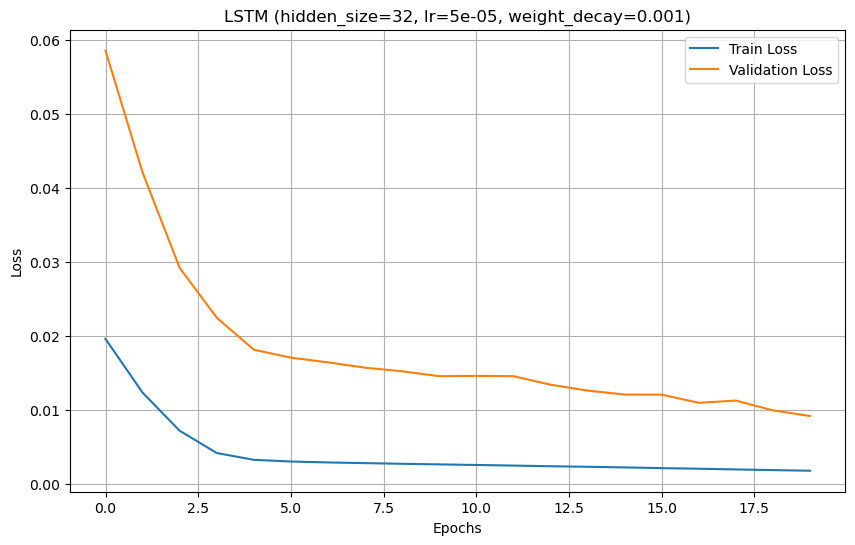

Training LSTM with hidden_size=64, lr=0.0001, weight_decay=0.0001
Epoch [1/20], Train Loss: 0.0061, Val Loss: 0.0212
Epoch [2/20], Train Loss: 0.0032, Val Loss: 0.0160
Epoch [3/20], Train Loss: 0.0026, Val Loss: 0.0116
Epoch [4/20], Train Loss: 0.0014, Val Loss: 0.0013
Epoch [5/20], Train Loss: 0.0004, Val Loss: 0.0001
Epoch [6/20], Train Loss: 0.0003, Val Loss: 0.0001
Epoch [7/20], Train Loss: 0.0003, Val Loss: 0.0001
Epoch [8/20], Train Loss: 0.0003, Val Loss: 0.0001
Epoch [9/20], Train Loss: 0.0003, Val Loss: 0.0001
Epoch [10/20], Train Loss: 0.0003, Val Loss: 0.0001
Epoch [11/20], Train Loss: 0.0003, Val Loss: 0.0001
Epoch [12/20], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [13/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [14/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [15/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [16/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [17/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [18/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [

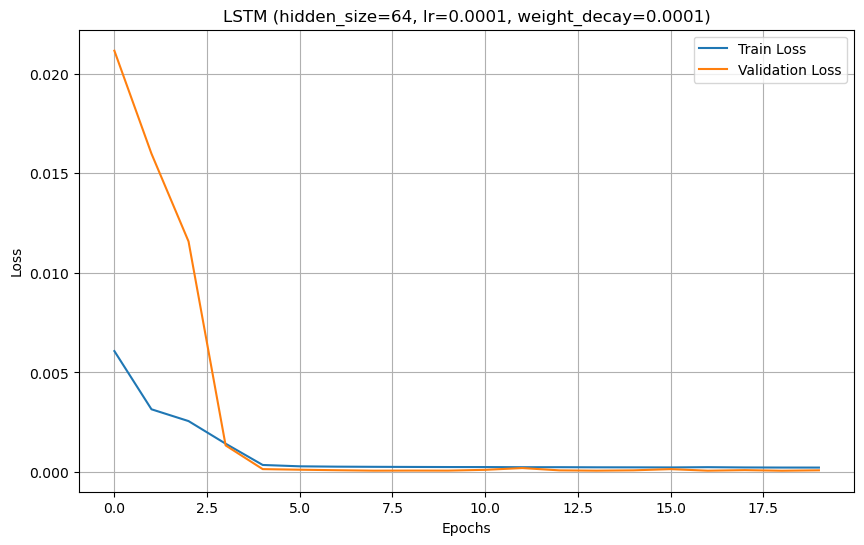

Training LSTM with hidden_size=64, lr=0.0001, weight_decay=0.001
Epoch [1/20], Train Loss: 0.0087, Val Loss: 0.0250
Epoch [2/20], Train Loss: 0.0032, Val Loss: 0.0164
Epoch [3/20], Train Loss: 0.0028, Val Loss: 0.0139
Epoch [4/20], Train Loss: 0.0024, Val Loss: 0.0125
Epoch [5/20], Train Loss: 0.0022, Val Loss: 0.0116
Epoch [6/20], Train Loss: 0.0019, Val Loss: 0.0094
Epoch [7/20], Train Loss: 0.0017, Val Loss: 0.0074
Epoch [8/20], Train Loss: 0.0013, Val Loss: 0.0053
Epoch [9/20], Train Loss: 0.0009, Val Loss: 0.0035
Epoch [10/20], Train Loss: 0.0006, Val Loss: 0.0019
Epoch [11/20], Train Loss: 0.0004, Val Loss: 0.0011
Epoch [12/20], Train Loss: 0.0003, Val Loss: 0.0008
Epoch [13/20], Train Loss: 0.0003, Val Loss: 0.0009
Epoch [14/20], Train Loss: 0.0003, Val Loss: 0.0007
Epoch [15/20], Train Loss: 0.0003, Val Loss: 0.0008
Epoch [16/20], Train Loss: 0.0003, Val Loss: 0.0006
Epoch [17/20], Train Loss: 0.0003, Val Loss: 0.0006
Epoch [18/20], Train Loss: 0.0003, Val Loss: 0.0006
Epoch [1

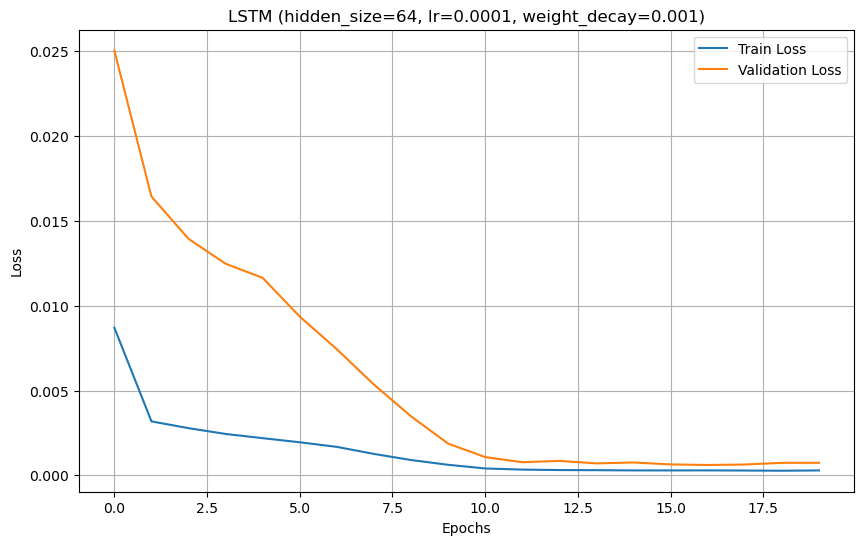

Training LSTM with hidden_size=64, lr=5e-05, weight_decay=0.0001
Epoch [1/20], Train Loss: 0.0150, Val Loss: 0.0465
Epoch [2/20], Train Loss: 0.0071, Val Loss: 0.0255
Epoch [3/20], Train Loss: 0.0035, Val Loss: 0.0178
Epoch [4/20], Train Loss: 0.0031, Val Loss: 0.0163
Epoch [5/20], Train Loss: 0.0028, Val Loss: 0.0143
Epoch [6/20], Train Loss: 0.0025, Val Loss: 0.0122
Epoch [7/20], Train Loss: 0.0021, Val Loss: 0.0091
Epoch [8/20], Train Loss: 0.0016, Val Loss: 0.0047
Epoch [9/20], Train Loss: 0.0010, Val Loss: 0.0017
Epoch [10/20], Train Loss: 0.0006, Val Loss: 0.0004
Epoch [11/20], Train Loss: 0.0005, Val Loss: 0.0002
Epoch [12/20], Train Loss: 0.0004, Val Loss: 0.0002
Epoch [13/20], Train Loss: 0.0004, Val Loss: 0.0002
Epoch [14/20], Train Loss: 0.0004, Val Loss: 0.0001
Epoch [15/20], Train Loss: 0.0003, Val Loss: 0.0001
Epoch [16/20], Train Loss: 0.0003, Val Loss: 0.0001
Epoch [17/20], Train Loss: 0.0003, Val Loss: 0.0001
Epoch [18/20], Train Loss: 0.0003, Val Loss: 0.0001
Epoch [1

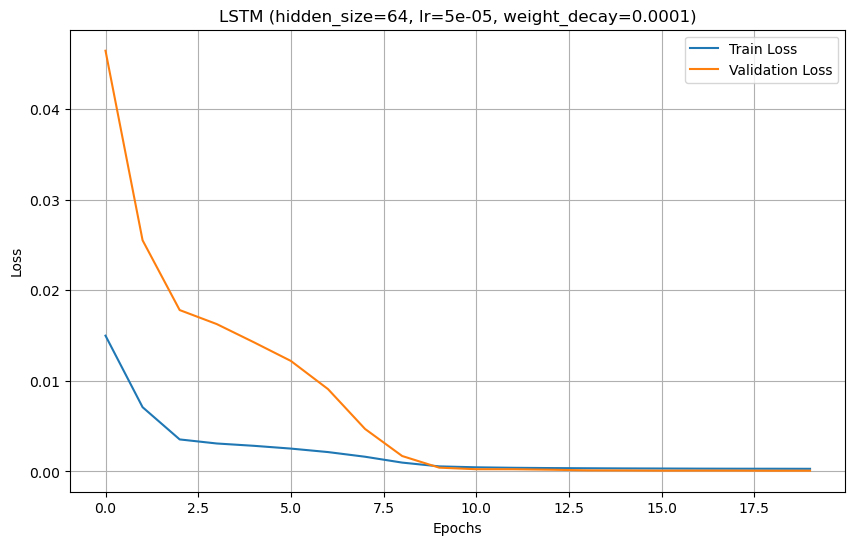

Training LSTM with hidden_size=64, lr=5e-05, weight_decay=0.001
Epoch [1/20], Train Loss: 0.0108, Val Loss: 0.0360
Epoch [2/20], Train Loss: 0.0058, Val Loss: 0.0255
Epoch [3/20], Train Loss: 0.0036, Val Loss: 0.0195
Epoch [4/20], Train Loss: 0.0030, Val Loss: 0.0173
Epoch [5/20], Train Loss: 0.0028, Val Loss: 0.0156
Epoch [6/20], Train Loss: 0.0027, Val Loss: 0.0146
Epoch [7/20], Train Loss: 0.0025, Val Loss: 0.0135
Epoch [8/20], Train Loss: 0.0024, Val Loss: 0.0126
Epoch [9/20], Train Loss: 0.0022, Val Loss: 0.0116
Epoch [10/20], Train Loss: 0.0021, Val Loss: 0.0115
Epoch [11/20], Train Loss: 0.0019, Val Loss: 0.0097
Epoch [12/20], Train Loss: 0.0017, Val Loss: 0.0087
Epoch [13/20], Train Loss: 0.0015, Val Loss: 0.0079
Epoch [14/20], Train Loss: 0.0013, Val Loss: 0.0059
Epoch [15/20], Train Loss: 0.0011, Val Loss: 0.0048
Epoch [16/20], Train Loss: 0.0009, Val Loss: 0.0036
Epoch [17/20], Train Loss: 0.0007, Val Loss: 0.0027
Epoch [18/20], Train Loss: 0.0005, Val Loss: 0.0020
Epoch [19

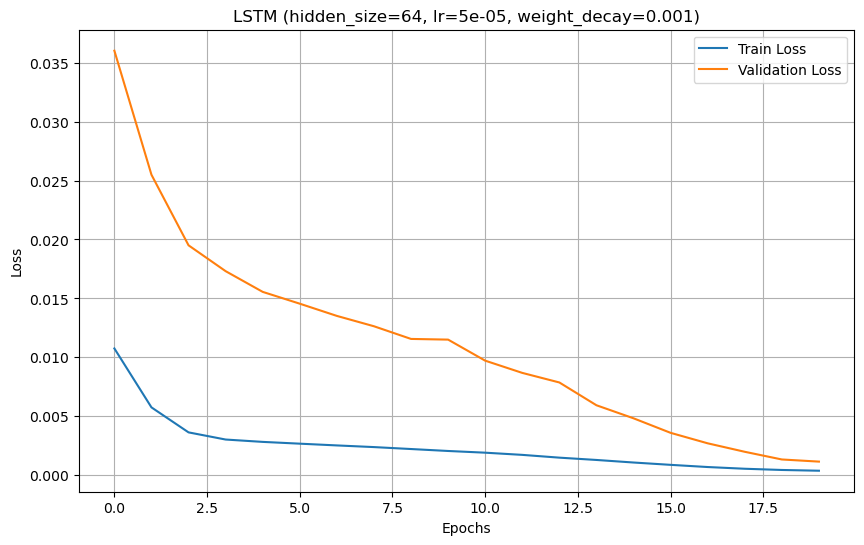

Tuning GRU...
Training GRU with hidden_size=32, lr=0.0001, weight_decay=0.0001
Epoch [1/20], Train Loss: 0.0139, Val Loss: 0.0383
Epoch [2/20], Train Loss: 0.0049, Val Loss: 0.0222
Epoch [3/20], Train Loss: 0.0034, Val Loss: 0.0187
Epoch [4/20], Train Loss: 0.0031, Val Loss: 0.0163
Epoch [5/20], Train Loss: 0.0029, Val Loss: 0.0143
Epoch [6/20], Train Loss: 0.0024, Val Loss: 0.0125
Epoch [7/20], Train Loss: 0.0021, Val Loss: 0.0099
Epoch [8/20], Train Loss: 0.0016, Val Loss: 0.0076
Epoch [9/20], Train Loss: 0.0012, Val Loss: 0.0041
Epoch [10/20], Train Loss: 0.0007, Val Loss: 0.0017
Epoch [11/20], Train Loss: 0.0004, Val Loss: 0.0005
Epoch [12/20], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [13/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [14/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [15/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [16/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [17/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [18/20], Train Loss: 0.0002, Val Loss: 0

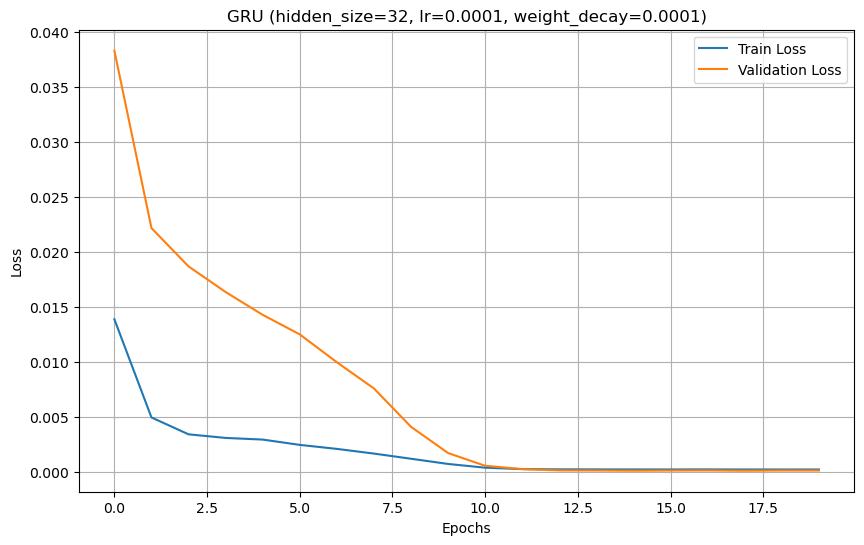

Training GRU with hidden_size=32, lr=0.0001, weight_decay=0.001
Epoch [1/20], Train Loss: 0.0378, Val Loss: 0.0733
Epoch [2/20], Train Loss: 0.0147, Val Loss: 0.0373
Epoch [3/20], Train Loss: 0.0047, Val Loss: 0.0202
Epoch [4/20], Train Loss: 0.0032, Val Loss: 0.0179
Epoch [5/20], Train Loss: 0.0029, Val Loss: 0.0165
Epoch [6/20], Train Loss: 0.0027, Val Loss: 0.0144
Epoch [7/20], Train Loss: 0.0025, Val Loss: 0.0143
Epoch [8/20], Train Loss: 0.0024, Val Loss: 0.0127
Epoch [9/20], Train Loss: 0.0021, Val Loss: 0.0116
Epoch [10/20], Train Loss: 0.0020, Val Loss: 0.0105
Epoch [11/20], Train Loss: 0.0018, Val Loss: 0.0089
Epoch [12/20], Train Loss: 0.0016, Val Loss: 0.0082
Epoch [13/20], Train Loss: 0.0014, Val Loss: 0.0066
Epoch [14/20], Train Loss: 0.0012, Val Loss: 0.0055
Epoch [15/20], Train Loss: 0.0010, Val Loss: 0.0045
Epoch [16/20], Train Loss: 0.0008, Val Loss: 0.0038
Epoch [17/20], Train Loss: 0.0007, Val Loss: 0.0026
Epoch [18/20], Train Loss: 0.0005, Val Loss: 0.0023
Epoch [19

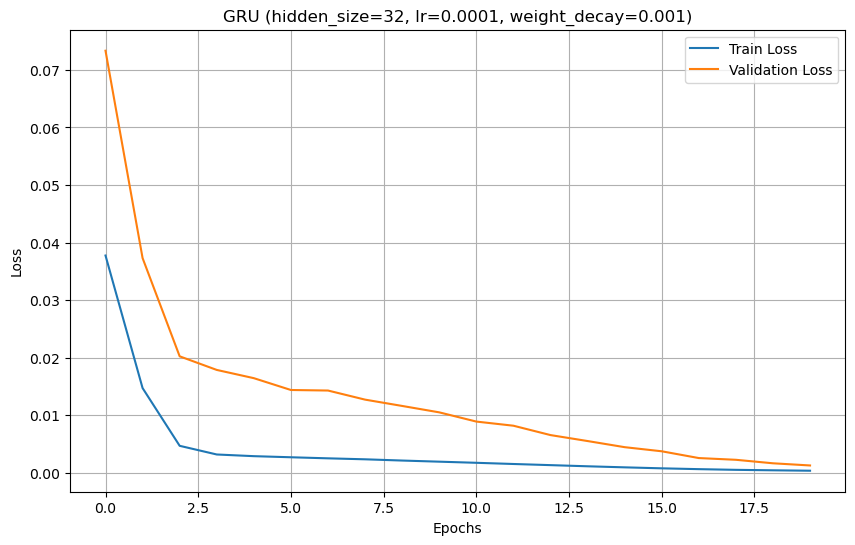

Training GRU with hidden_size=32, lr=5e-05, weight_decay=0.0001
Epoch [1/20], Train Loss: 0.0191, Val Loss: 0.0403
Epoch [2/20], Train Loss: 0.0104, Val Loss: 0.0277
Epoch [3/20], Train Loss: 0.0054, Val Loss: 0.0193
Epoch [4/20], Train Loss: 0.0035, Val Loss: 0.0167
Epoch [5/20], Train Loss: 0.0029, Val Loss: 0.0156
Epoch [6/20], Train Loss: 0.0027, Val Loss: 0.0143
Epoch [7/20], Train Loss: 0.0025, Val Loss: 0.0135
Epoch [8/20], Train Loss: 0.0023, Val Loss: 0.0117
Epoch [9/20], Train Loss: 0.0021, Val Loss: 0.0110
Epoch [10/20], Train Loss: 0.0020, Val Loss: 0.0100
Epoch [11/20], Train Loss: 0.0018, Val Loss: 0.0089
Epoch [12/20], Train Loss: 0.0015, Val Loss: 0.0075
Epoch [13/20], Train Loss: 0.0013, Val Loss: 0.0060
Epoch [14/20], Train Loss: 0.0011, Val Loss: 0.0050
Epoch [15/20], Train Loss: 0.0009, Val Loss: 0.0039
Epoch [16/20], Train Loss: 0.0007, Val Loss: 0.0028
Epoch [17/20], Train Loss: 0.0006, Val Loss: 0.0020
Epoch [18/20], Train Loss: 0.0005, Val Loss: 0.0014
Epoch [19

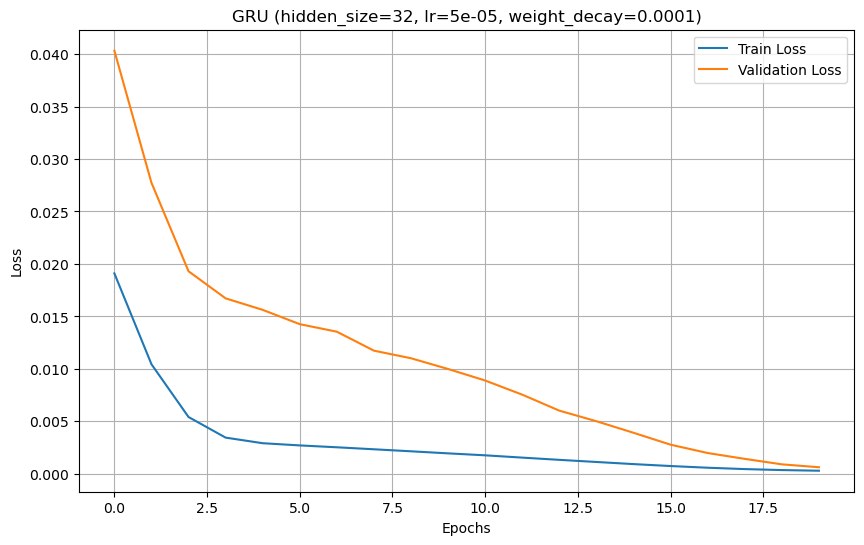

Training GRU with hidden_size=32, lr=5e-05, weight_decay=0.001
Epoch [1/20], Train Loss: 0.0174, Val Loss: 0.0401
Epoch [2/20], Train Loss: 0.0098, Val Loss: 0.0300
Epoch [3/20], Train Loss: 0.0057, Val Loss: 0.0232
Epoch [4/20], Train Loss: 0.0038, Val Loss: 0.0191
Epoch [5/20], Train Loss: 0.0031, Val Loss: 0.0171
Epoch [6/20], Train Loss: 0.0028, Val Loss: 0.0151
Epoch [7/20], Train Loss: 0.0027, Val Loss: 0.0145
Epoch [8/20], Train Loss: 0.0025, Val Loss: 0.0136
Epoch [9/20], Train Loss: 0.0023, Val Loss: 0.0128
Epoch [10/20], Train Loss: 0.0022, Val Loss: 0.0118
Epoch [11/20], Train Loss: 0.0021, Val Loss: 0.0109
Epoch [12/20], Train Loss: 0.0019, Val Loss: 0.0101
Epoch [13/20], Train Loss: 0.0018, Val Loss: 0.0094
Epoch [14/20], Train Loss: 0.0017, Val Loss: 0.0088
Epoch [15/20], Train Loss: 0.0015, Val Loss: 0.0079
Epoch [16/20], Train Loss: 0.0014, Val Loss: 0.0072
Epoch [17/20], Train Loss: 0.0014, Val Loss: 0.0063
Epoch [18/20], Train Loss: 0.0011, Val Loss: 0.0056
Epoch [19/

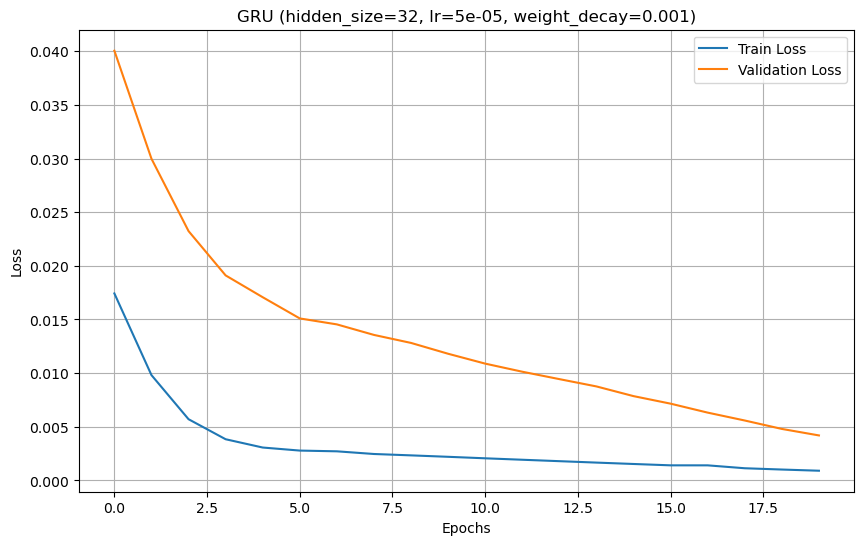

Training GRU with hidden_size=64, lr=0.0001, weight_decay=0.0001
Epoch [1/20], Train Loss: 0.0097, Val Loss: 0.0247
Epoch [2/20], Train Loss: 0.0032, Val Loss: 0.0145
Epoch [3/20], Train Loss: 0.0024, Val Loss: 0.0103
Epoch [4/20], Train Loss: 0.0016, Val Loss: 0.0055
Epoch [5/20], Train Loss: 0.0007, Val Loss: 0.0006
Epoch [6/20], Train Loss: 0.0003, Val Loss: 0.0001
Epoch [7/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [8/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [9/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [10/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [11/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [12/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [13/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [14/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [15/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [16/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [17/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [18/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [1

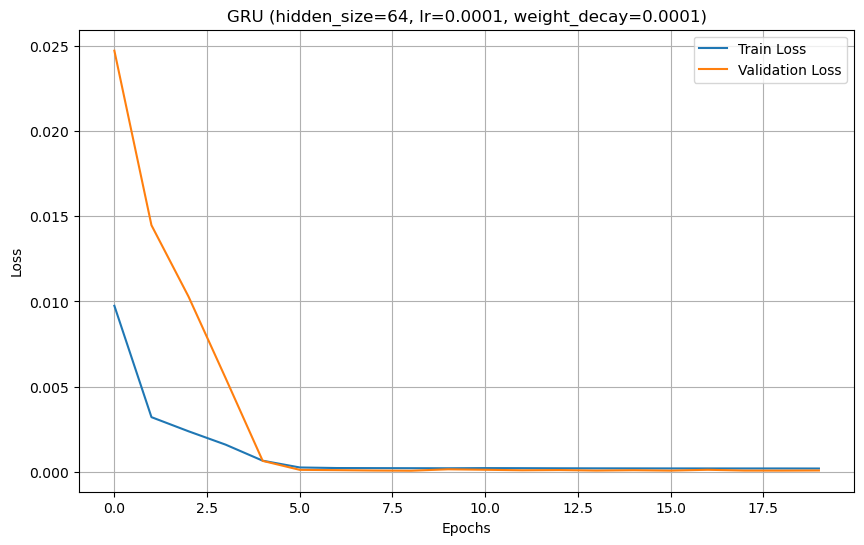

Training GRU with hidden_size=64, lr=0.0001, weight_decay=0.001
Epoch [1/20], Train Loss: 0.0134, Val Loss: 0.0229
Epoch [2/20], Train Loss: 0.0032, Val Loss: 0.0143
Epoch [3/20], Train Loss: 0.0023, Val Loss: 0.0115
Epoch [4/20], Train Loss: 0.0019, Val Loss: 0.0087
Epoch [5/20], Train Loss: 0.0014, Val Loss: 0.0060
Epoch [6/20], Train Loss: 0.0010, Val Loss: 0.0037
Epoch [7/20], Train Loss: 0.0006, Val Loss: 0.0020
Epoch [8/20], Train Loss: 0.0004, Val Loss: 0.0011
Epoch [9/20], Train Loss: 0.0003, Val Loss: 0.0008
Epoch [10/20], Train Loss: 0.0003, Val Loss: 0.0007
Epoch [11/20], Train Loss: 0.0003, Val Loss: 0.0007
Epoch [12/20], Train Loss: 0.0003, Val Loss: 0.0007
Epoch [13/20], Train Loss: 0.0002, Val Loss: 0.0006
Epoch [14/20], Train Loss: 0.0002, Val Loss: 0.0006
Epoch [15/20], Train Loss: 0.0002, Val Loss: 0.0005
Epoch [16/20], Train Loss: 0.0002, Val Loss: 0.0005
Epoch [17/20], Train Loss: 0.0002, Val Loss: 0.0005
Epoch [18/20], Train Loss: 0.0002, Val Loss: 0.0006
Epoch [19

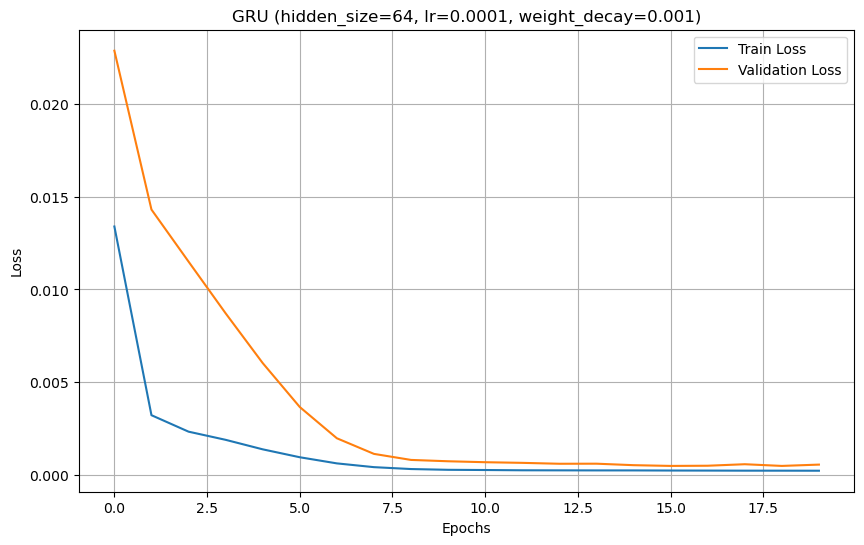

Training GRU with hidden_size=64, lr=5e-05, weight_decay=0.0001
Epoch [1/20], Train Loss: 0.0069, Val Loss: 0.0220
Epoch [2/20], Train Loss: 0.0040, Val Loss: 0.0196
Epoch [3/20], Train Loss: 0.0033, Val Loss: 0.0181
Epoch [4/20], Train Loss: 0.0029, Val Loss: 0.0150
Epoch [5/20], Train Loss: 0.0024, Val Loss: 0.0118
Epoch [6/20], Train Loss: 0.0018, Val Loss: 0.0077
Epoch [7/20], Train Loss: 0.0011, Val Loss: 0.0032
Epoch [8/20], Train Loss: 0.0005, Val Loss: 0.0005
Epoch [9/20], Train Loss: 0.0003, Val Loss: 0.0002
Epoch [10/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [11/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [12/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [13/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [14/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [15/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [16/20], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [17/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [18/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [19

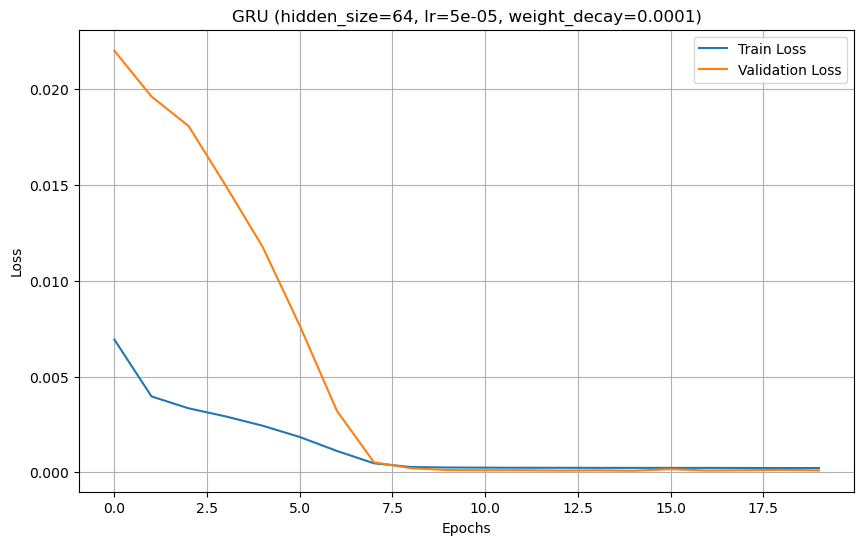

Training GRU with hidden_size=64, lr=5e-05, weight_decay=0.001
Epoch [1/20], Train Loss: 0.0119, Val Loss: 0.0344
Epoch [2/20], Train Loss: 0.0046, Val Loss: 0.0206
Epoch [3/20], Train Loss: 0.0030, Val Loss: 0.0158
Epoch [4/20], Train Loss: 0.0027, Val Loss: 0.0149
Epoch [5/20], Train Loss: 0.0025, Val Loss: 0.0132
Epoch [6/20], Train Loss: 0.0023, Val Loss: 0.0121
Epoch [7/20], Train Loss: 0.0021, Val Loss: 0.0103
Epoch [8/20], Train Loss: 0.0019, Val Loss: 0.0096
Epoch [9/20], Train Loss: 0.0017, Val Loss: 0.0082
Epoch [10/20], Train Loss: 0.0015, Val Loss: 0.0070
Epoch [11/20], Train Loss: 0.0012, Val Loss: 0.0061
Epoch [12/20], Train Loss: 0.0011, Val Loss: 0.0048
Epoch [13/20], Train Loss: 0.0009, Val Loss: 0.0037
Epoch [14/20], Train Loss: 0.0007, Val Loss: 0.0028
Epoch [15/20], Train Loss: 0.0006, Val Loss: 0.0022
Epoch [16/20], Train Loss: 0.0005, Val Loss: 0.0018
Epoch [17/20], Train Loss: 0.0004, Val Loss: 0.0014
Epoch [18/20], Train Loss: 0.0004, Val Loss: 0.0010
Epoch [19/

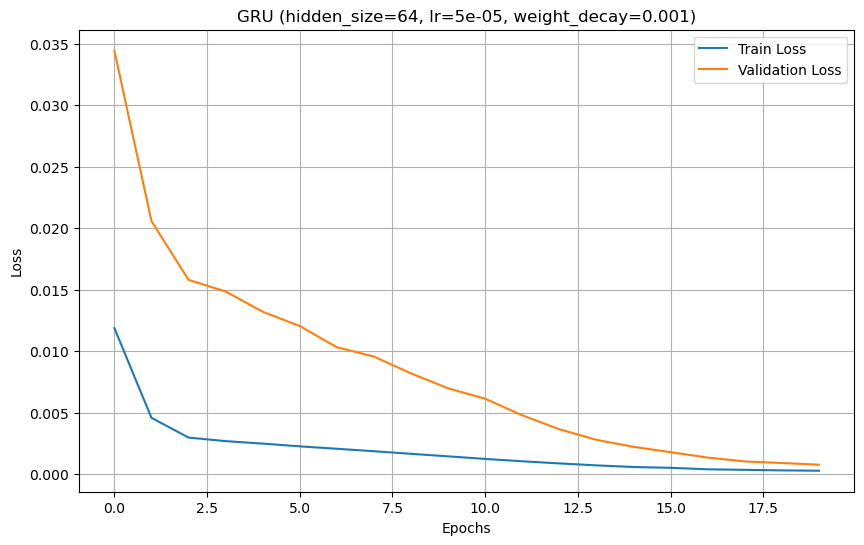


Best Hyperparameters:
Vanilla RNN: {'hidden_size': 64, 'lr': 0.0001, 'weight_decay': 0.0001}
LSTM: {'hidden_size': 64, 'lr': 0.0001, 'weight_decay': 0.0001}
GRU: {'hidden_size': 64, 'lr': 0.0001, 'weight_decay': 0.0001}


In [15]:
def prepare_dataloader(X, y, batch_size):
    dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model Training Functions
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    train_losses, val_losses = [], []
    best_val_loss = float("inf")
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    model.load_state_dict(best_model_state)
    return model, train_losses, val_losses

# Plotting training and validation loss curves
def plot_loss_curve(train_losses, val_losses, title):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

def hyperparameter_tuning(X_train, y_train, X_val, y_val, input_size, output_size, model_type, param_grid, num_epochs):
    results = []
    best_val_loss = float("inf")
    best_model_state = None
    best_hyperparams = None 

    for hidden_size in param_grid['hidden_size']:
        for lr in param_grid['lr']:
            for weight_decay in param_grid['weight_decay']:
                print(f"Training {model_type} with hidden_size={hidden_size}, lr={lr}, weight_decay={weight_decay}")
                if model_type == 'VanillaRNN':
                    model = VanillaRNN(input_size, hidden_size, output_size).to(device)
                elif model_type == 'LSTM':
                    model = LSTM(input_size, hidden_size, output_size).to(device)
                elif model_type == 'GRU':
                    model = GRU(input_size, hidden_size, output_size).to(device)

                criterion = nn.MSELoss()
                optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
                train_loader = prepare_dataloader(X_train, y_train, param_grid['batch_size'])
                val_loader = prepare_dataloader(X_val, y_val, param_grid['batch_size'])

                # training model
                model, train_losses, val_losses = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs)
                val_loss = min(val_losses) 

                results.append({'hidden_size': hidden_size, 'lr': lr, 'weight_decay': weight_decay, 
                                'train_losses': train_losses, 'val_losses': val_losses, 'model_state': model.state_dict()})

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model_state = model.state_dict()

                plot_loss_curve(train_losses, val_losses, f"{model_type} (hidden_size={hidden_size}, lr={lr}, weight_decay={weight_decay})")
    return results, best_model_state, best_hyperparams

if __name__ == "__main__":
    (X_train, y_train, _), (X_val, y_val, _), (X_test, y_test, _), scaler = preprocess_data(data)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # hyperparametric lattice
    param_grid = {
        'hidden_size': [32, 64],
        'lr': [1e-4, 5e-5],
        'weight_decay': [1e-4, 1e-3],
        'batch_size': 32
    }
    num_epochs = 20
    input_size = X_train.shape[2]
    output_size = y_train.shape[1]

    # Vanilla RNN
    print("Tuning Vanilla RNN...")
    rnn_results, rnn_best_model_state, rnn_best_hyperparams = hyperparameter_tuning(
        X_train, y_train, X_val, y_val, input_size, output_size, 'VanillaRNN', param_grid, num_epochs)

    # LSTM
    print("Tuning LSTM...")
    lstm_results, lstm_best_model_state, lstm_best_hyperparams = hyperparameter_tuning(
        X_train, y_train, X_val, y_val, input_size, output_size, 'LSTM', param_grid, num_epochs)

    # GRU
    print("Tuning GRU...")
    gru_results, gru_best_model_state, gru_best_hyperparams = hyperparameter_tuning(
        X_train, y_train, X_val, y_val, input_size, output_size, 'GRU', param_grid, num_epochs)

    print("\nBest Hyperparameters:")
    print(f"Vanilla RNN: {rnn_best_hyperparams}")
    print(f"LSTM: {lstm_best_hyperparams}")
    print(f"GRU: {gru_best_hyperparams}")

    torch.save(rnn_best_model_state, "vanilla_rnn_best.pth")
    torch.save(lstm_best_model_state, "lstm_best.pth")
    torch.save(gru_best_model_state, "gru_best.pth")

F:\anaconda\envs\Deeplearning_new\lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



Evaluating Vanilla RNN...
Model Evaluation Metrics:
MSE: 0.01086, RMSE: 0.10420, MAE: 0.07999, R²: 0.69797, Directional Accuracy: 0.50650

Evaluating LSTM...
Model Evaluation Metrics:
MSE: 0.01397, RMSE: 0.11818, MAE: 0.09021, R²: 0.61150, Directional Accuracy: 0.52038

Evaluating GRU...
Model Evaluation Metrics:
MSE: 0.00347, RMSE: 0.05889, MAE: 0.04557, R²: 0.90352, Directional Accuracy: 0.52125

Visualizing Vanilla RNN Predictions...


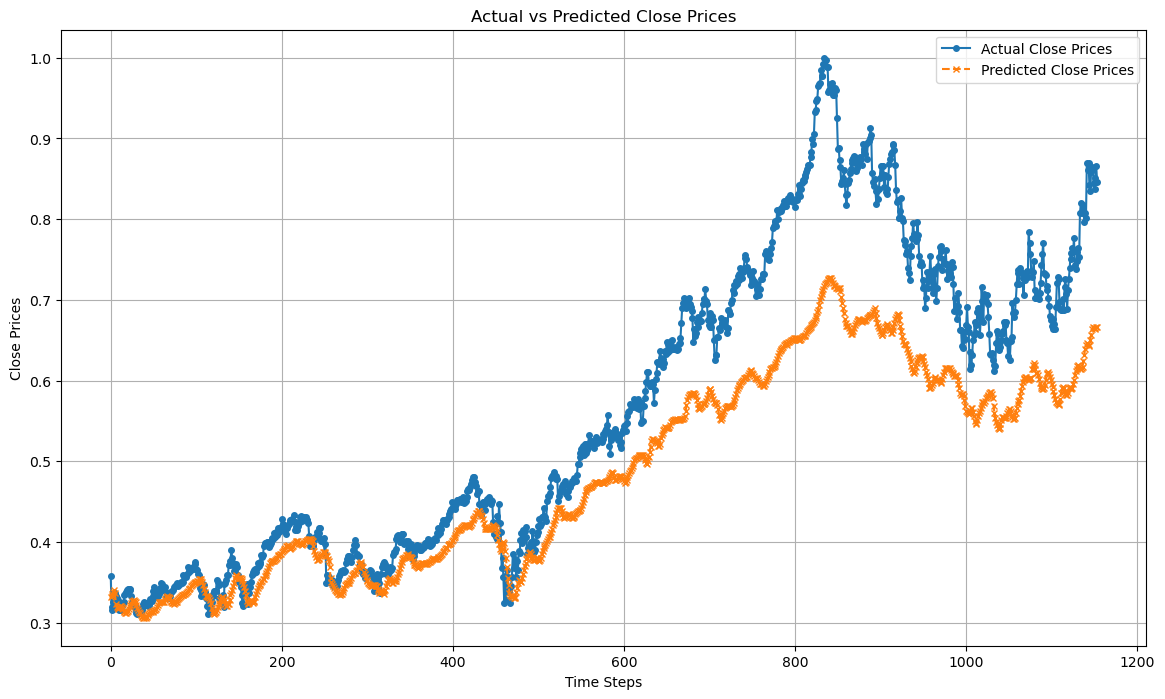

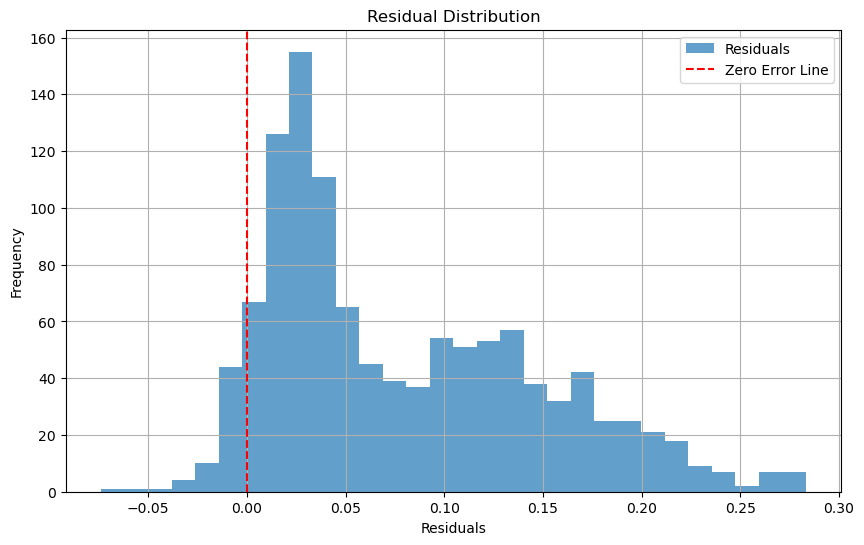


Visualizing LSTM Predictions...


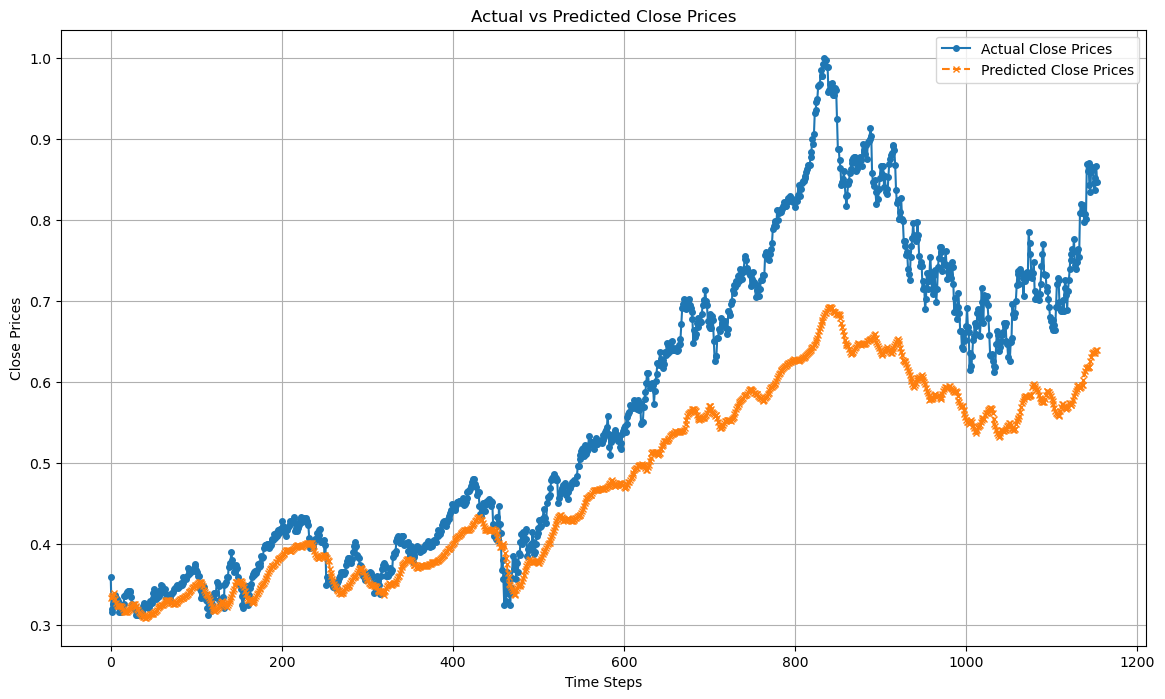

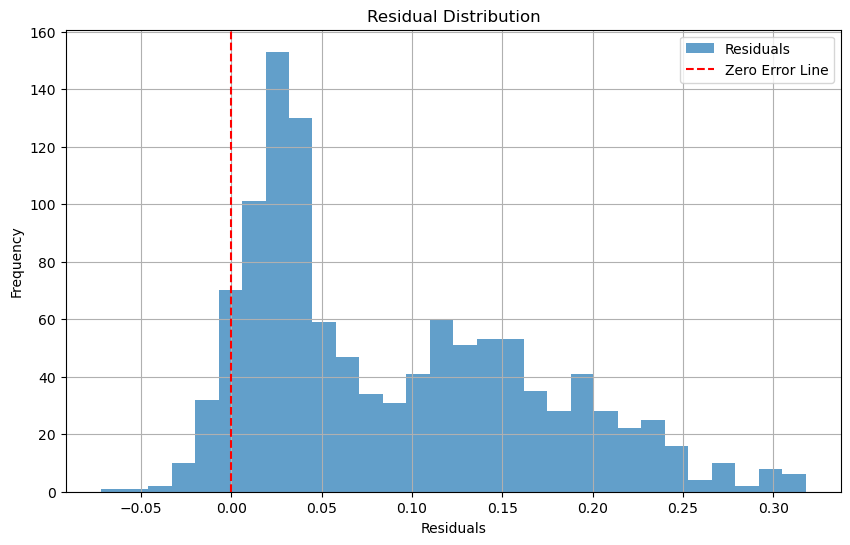


Visualizing GRU Predictions...


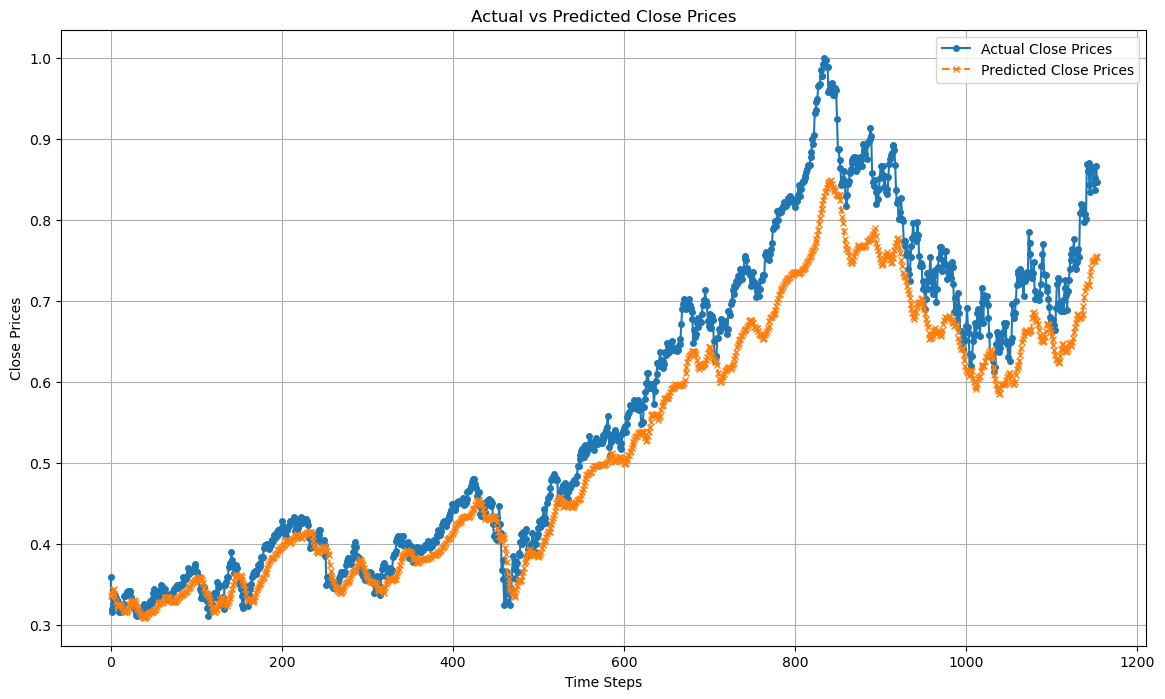

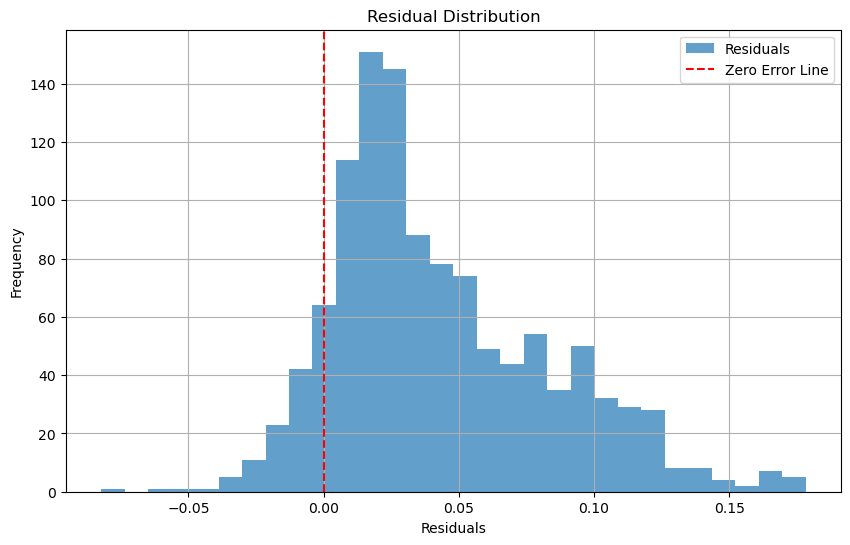

In [30]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Test Set Evaluation Functions
def evaluate_model(model, X_test, y_test, feature_index=3):
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)
        predictions = model(X_test_tensor).cpu().numpy()

    # Extract the true and predicted values of the Close column
    y_test_close = y_test[:, feature_index]  
    predictions_close = predictions[:, feature_index]  
    # Calculation of indicators
    mse = mean_squared_error(y_test_close, predictions_close)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_close, predictions_close)
    r2 = r2_score(y_test_close, predictions_close)

    # Predictive direction accuracy
    true_directions = np.sign(y_test_close[1:] - y_test_close[:-1])  
    pred_directions = np.sign(predictions_close[1:] - predictions_close[:-1])  
    directional_accuracy = np.mean(true_directions == pred_directions)

    print(f"Model Evaluation Metrics:")
    print(f"MSE: {mse:.5f}, RMSE: {rmse:.5f}, MAE: {mae:.5f}, R²: {r2:.5f}, Directional Accuracy: {directional_accuracy:.5f}")

    return y_test_close, predictions_close, mse, rmse, mae, r2, directional_accuracy

# Visualize predicted versus true values
def plot_predictions(y_test_close, predictions_close):
    plt.figure(figsize=(14, 8))
    plt.plot(y_test_close, label="Actual Close Prices", linestyle="-", marker="o", markersize=4)
    plt.plot(predictions_close, label="Predicted Close Prices", linestyle="--", marker="x", markersize=4)
    plt.xlabel("Time Steps")
    plt.ylabel("Close Prices")
    plt.title("Actual vs Predicted Close Prices")
    plt.legend()
    plt.grid()
    plt.show()

# Visualization of residual distributions
def plot_residuals(y_test_close, predictions_close):
    residuals = y_test_close - predictions_close
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=30, alpha=0.7, label="Residuals")
    plt.axvline(x=0, color="red", linestyle="--", label="Zero Error Line")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.title("Residual Distribution")
    plt.legend()
    plt.grid()
    plt.show()

if __name__ == "__main__":
    (X_train, y_train, _), (X_val, y_val, _), (X_test, y_test, _), scaler = preprocess_data(data)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load the best model
    rnn_model = VanillaRNN(input_size, rnn_best_hyperparams['hidden_size'], output_size).to(device)
    rnn_model.load_state_dict(torch.load("vanilla_rnn_best.pth"))
    lstm_model = LSTM(input_size, lstm_best_hyperparams['hidden_size'], output_size).to(device)
    lstm_model.load_state_dict(torch.load("lstm_best.pth"))
    gru_model = GRU(input_size, gru_best_hyperparams['hidden_size'], output_size).to(device)
    gru_model.load_state_dict(torch.load("gru_best.pth"))

    # RNN 
    print("\nEvaluating Vanilla RNN...")
    y_test_rnn, predictions_rnn, mse_rnn, rmse_rnn, mae_rnn, r2_rnn, acc_rnn = evaluate_model(rnn_model, X_test, y_test)

    # LSTM 
    print("\nEvaluating LSTM...")
    y_test_lstm, predictions_lstm, mse_lstm, rmse_lstm, mae_lstm, r2_lstm, acc_lstm = evaluate_model(lstm_model, X_test, y_test)

    # GRU 
    print("\nEvaluating GRU...")
    y_test_gru, predictions_gru, mse_gru, rmse_gru, mae_gru, r2_gru, acc_gru = evaluate_model(gru_model, X_test, y_test)

    print("\nVisualizing Vanilla RNN Predictions...")
    plot_predictions(y_test_rnn, predictions_rnn)
    plot_residuals(y_test_rnn, predictions_rnn)

    print("\nVisualizing LSTM Predictions...")
    plot_predictions(y_test_lstm, predictions_lstm)
    plot_residuals(y_test_lstm, predictions_lstm)

    print("\nVisualizing GRU Predictions...")
    plot_predictions(y_test_gru, predictions_gru)
    plot_residuals(y_test_gru, predictions_gru)
